# Predict the mortality of ICU stay after 24 hours

- Using 3 large hospitals to train
- 2 others combined to test
- all from eICU dataset. 

- inputs are apache variables and most common lab values

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import logging

from neoglia.workers.connect_workers import connect
from neoglia.learn.utils import setup_logging
from neoglia.learn.config import LearnConfig
from neoglia.learn.losses import binary_cross_entropy
from neoglia.learn.models import FFNet
from neoglia.learn.learner import Learner

In [3]:
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

## Connect to data nodes

In this demo, we have 3 distinct hospitals. Each is an indenpendent EC2 instance on AWS.

In [4]:
h1, h2, h3 = connect(local=True)

neoglia.workers.connect_workers - INFO - Connected to worker h1.
neoglia.workers.connect_workers - INFO - Connected to worker h2.
neoglia.workers.connect_workers - INFO - Connected to worker h3.


Check the datasets they have and the dimensions of these.

In [5]:
logger.info(h1.list_datasets())

root - INFO - -mnist_train:
	data size: [24754, 28, 28],
	target size: [24754]
-mnist_test:
	data size: [10000, 28, 28],
	target size: [10000]
-eicu_class_train:
	data size: [4778, 103],
	target size: [4778]
-eicu_class_test:
	data size: [5421, 103],
	target size: [5421]
-eicu_reg_train:
	data size: [4778, 103],
	target size: [4778]
-eicu_reg_test:
	data size: [5421, 103],
	target size: [5421]



## Train a convolutional neural network on the mnist dataset with federated averaging

Each hospital holds a subset of the training data but they all share the same test data.

## Define the config file for this experiment

This holds everything from the learning rate to the batch size. 

First let's check the available parameters. Note, this object can take a yml config file (good for reproducible experiments) or be parametrised when instantiated.

In [6]:
?LearnConfig

Init signature:
LearnConfig(
    config_file=None,
    train_dataset_name=None,
    test_dataset_name=None,
    train_batch_size=128,
    test_batch_size=128,
    train_epochs=100,
    fed_after_n_batches=10,
    metrics=['accuracy'],
    optimizer='SGD',
    optimizer_params={'lr': 0.1, 'momentum': 0.9},
    cuda=False,
    seed=42,
    save_model=True,
    verbose=True,
)
Docstring:      Config dict object, holding all parameters for the training and evaluation.
Init docstring:
Constructor of the subclassed dict object.

Args:
    config_file (str): Location of config YAML file. If provided, all
        parameters that are defined within will override the defaults here.
    train_dataset_name (str): Name of the remote dataset to train on.
    test_dataset_name (str): Name of the remote dataset to test on.
    train_batch_size (int): Batch size for training.
    test_batch_size (int): Batch size for evaluation.
    train_epochs (int): Number of epochs performed altogether for training

In [7]:
config = LearnConfig(config_file="config_eicu_mortality.yml")
config

{'config_file': 'config_eicu_mortality.yml',
 'train_dataset_name': 'eicu_class_train',
 'test_dataset_name': 'eicu_class_test',
 'train_batch_size': 512,
 'test_batch_size': 1024,
 'train_epochs': 50,
 'fed_after_n_batches': 10,
 'metrics': ['pr_curve', 'accuracy'],
 'optimizer': 'SGD',
 'optimizer_params': {'lr': 0.05, 'momentum': 0.9},
 'cuda': False,
 'seed': 42,
 'save_model': True,
 'verbose': True,
 'regression': False}

## Define model architecture and loss function

Define a model architecture in Torch, or simply load one of NeoGlia's predefined ones.

In [8]:
model = FFNet(
    input_d=103, 
    dense_size=1024,
    dropout_rate=0.5,
    final='sigmoid'
)

In [8]:
%psource FFNet

class FFNet(nn.Module):
    """
    Feed-forward network with dropout on tabular, numeric data.

    Returns probabilities after sigmoid and not logits.
    """
    def __init__(self, input_d, dense_size=256, dropout_rate=0.25, final=None):
        """
        Constructor of neural net.

        Args:
            input_d (int): Input dimensions to the first layers, i.e. num cols in data.
            dense_size (int): Size of the first layer. There are 3 layers in this
                architecture, the 2nd has dense_size/2 the 3rd has dense_size/4 units.
            dropout_rate (float): Rate of dropout applied to each fully connected layers.
            final (str): What should the final activation layer be. Options are:
                sigmoid, relu, None.
        """
        super(FFNet, self).__init__()
        self.fc1 = nn.Linear(input_d, dense_size)
        self.fc2 = nn.Linear(dense_size, int(dense_size/2))
        self.fc3 = nn.Linear(int(dense_size/2), int(dense_size/4))
     

We'll use cross entropy in this example as a loss function as this is a multi-class problem.

## Start training and evaluating the model in a federated manner. 

In [9]:
fed_learner = Learner(
    config=config,
    model=model, 
    model_input_dim=[1, 103],
    loss_fn=binary_cross_entropy, 
    workers=(h1, h2, h3)
)

neoglia.learn.learner - INFO - Starting epoch 1/50
neoglia.learn.learner - INFO - Training round: 1, worker: h2, avg_loss: 0.5710
neoglia.learn.learner - INFO - Training round: 1, worker: h1, avg_loss: 0.4309
neoglia.learn.learner - INFO - Training round: 1, worker: h3, avg_loss: 0.4474
neoglia.learn.learner - INFO - Starting epoch 2/50
neoglia.learn.learner - INFO - Training round: 2, worker: h2, avg_loss: 0.4122
neoglia.learn.learner - INFO - Training round: 2, worker: h1, avg_loss: 0.2925
neoglia.learn.learner - INFO - Training round: 2, worker: h3, avg_loss: 0.3433
neoglia.learn.learner - INFO - Starting epoch 3/50
neoglia.learn.learner - INFO - Training round: 3, worker: h2, avg_loss: 0.3733
neoglia.learn.learner - INFO - Training round: 3, worker: h3, avg_loss: 0.2569
neoglia.learn.learner - INFO - Training round: 3, worker: h1, avg_loss: 0.2167
neoglia.learn.learner - INFO - Starting epoch 4/50
neoglia.learn.learner - INFO - Training round: 4, worker: h2, avg_loss: 0.3152
neogli

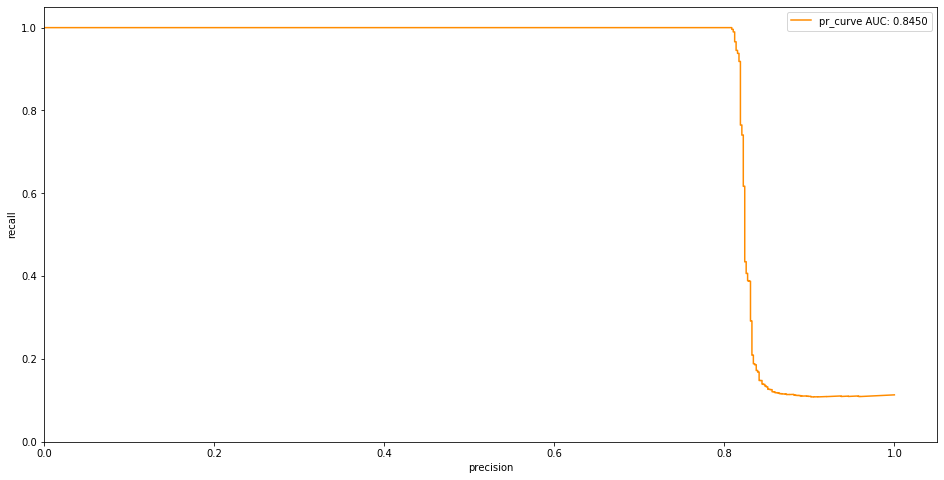

neoglia.learn.learner - INFO - 	- accuracy: 0.8910
neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0006


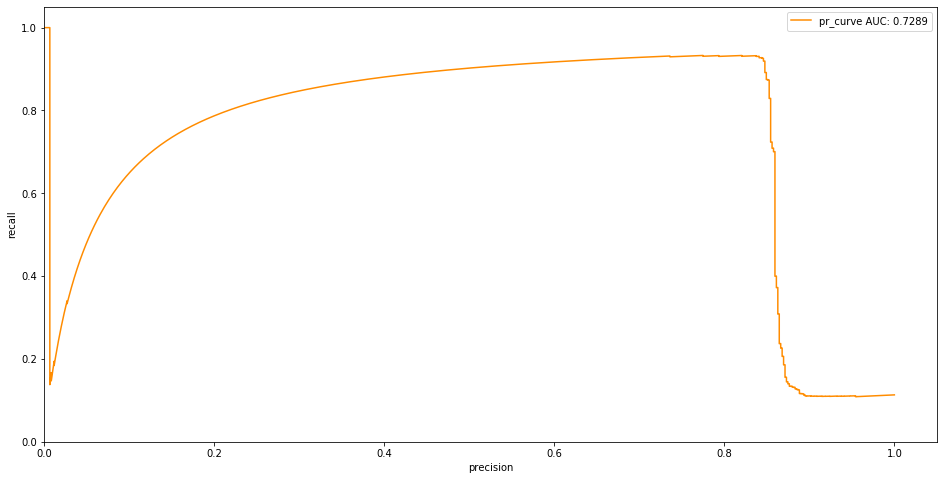

neoglia.learn.learner - INFO - 	- accuracy: 0.8939
neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0009


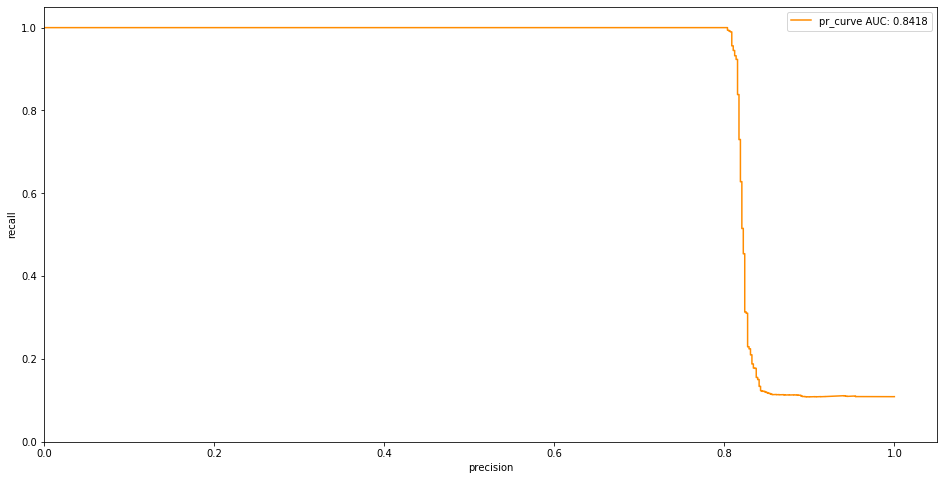

neoglia.learn.learner - INFO - 	- accuracy: 0.8912
neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0008


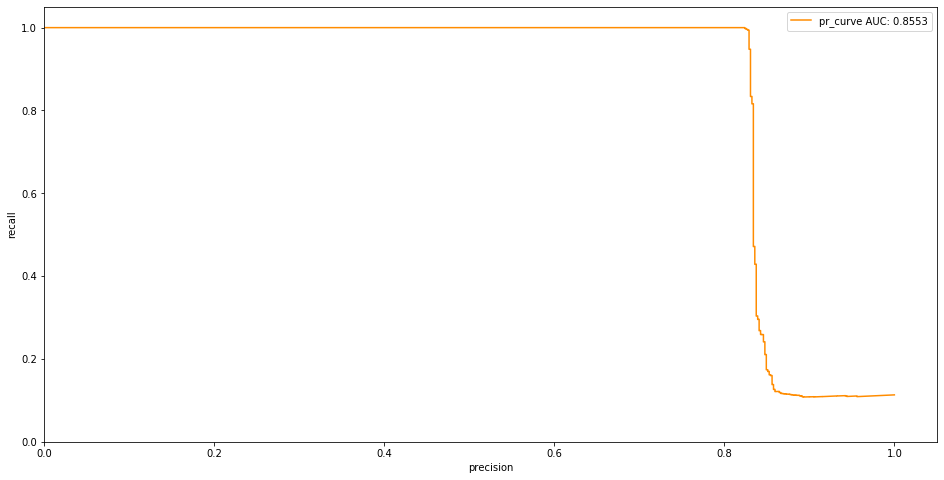

neoglia.learn.learner - INFO - 	- accuracy: 0.8915
neoglia.learn.learner - INFO - Starting epoch 11/50
neoglia.learn.learner - INFO - Training round: 11, worker: h2, avg_loss: 0.1162
neoglia.learn.learner - INFO - Training round: 11, worker: h1, avg_loss: 0.3310
neoglia.learn.learner - INFO - Training round: 11, worker: h3, avg_loss: 0.0292
neoglia.learn.learner - INFO - Starting epoch 12/50
neoglia.learn.learner - INFO - Training round: 12, worker: h2, avg_loss: 0.1351
neoglia.learn.learner - INFO - Training round: 12, worker: h3, avg_loss: 0.0330
neoglia.learn.learner - INFO - Training round: 12, worker: h1, avg_loss: 0.0310
neoglia.learn.learner - INFO - Starting epoch 13/50
neoglia.learn.learner - INFO - Training round: 13, worker: h2, avg_loss: 0.3237
neoglia.learn.learner - INFO - Training round: 13, worker: h1, avg_loss: 0.0135
neoglia.learn.learner - INFO - Training round: 13, worker: h3, avg_loss: 0.0239
neoglia.learn.learner - INFO - Starting epoch 14/50
neoglia.learn.learner

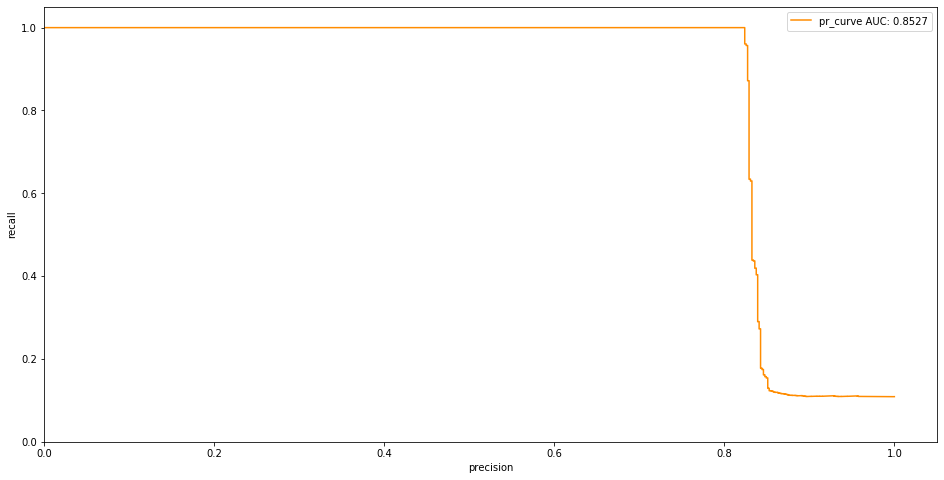

neoglia.learn.learner - INFO - 	- accuracy: 0.9043
neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0007


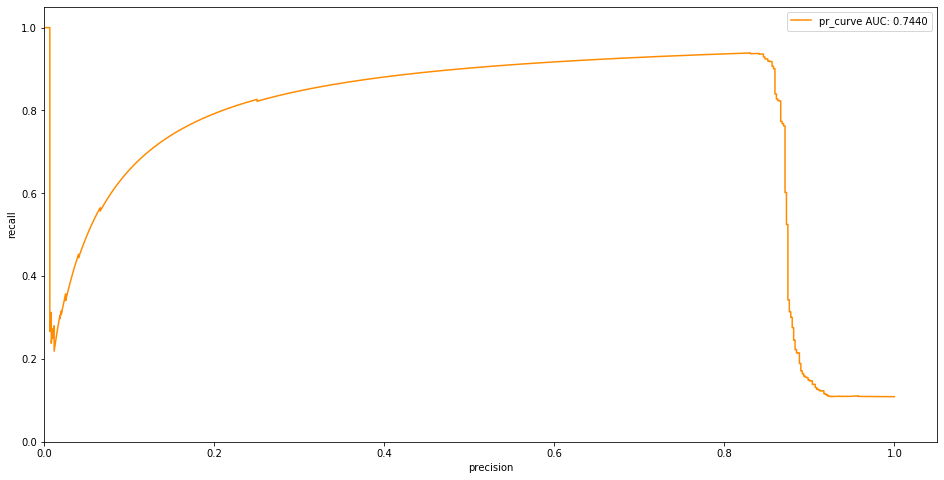

neoglia.learn.learner - INFO - 	- accuracy: 0.9343
neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0009


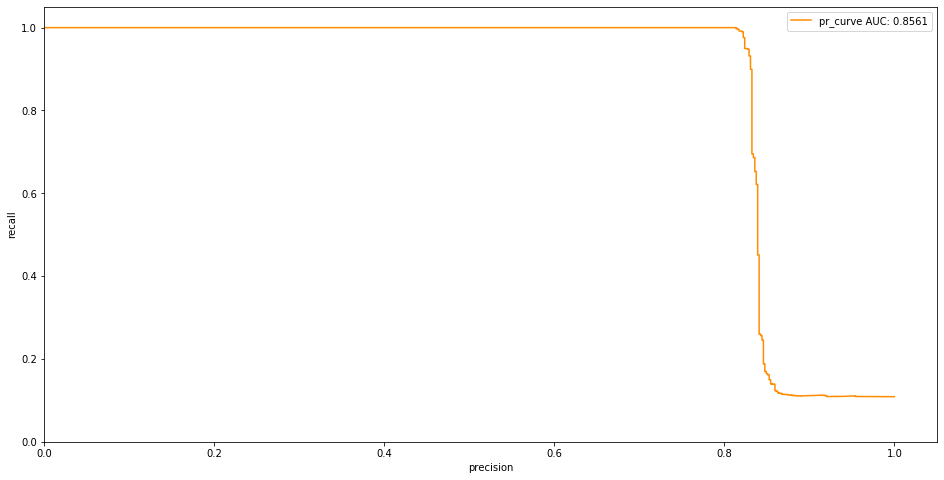

neoglia.learn.learner - INFO - 	- accuracy: 0.9083
neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0008


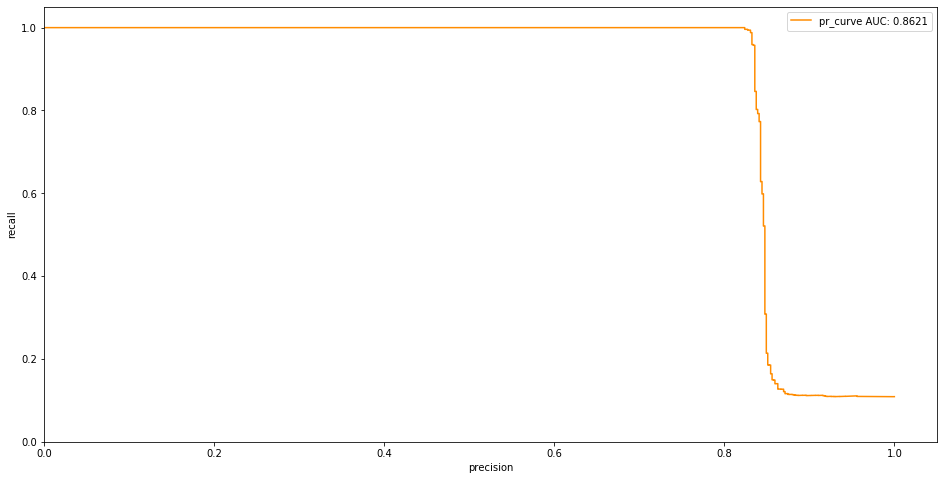

neoglia.learn.learner - INFO - 	- accuracy: 0.9161
neoglia.learn.learner - INFO - Starting epoch 21/50
neoglia.learn.learner - INFO - Training round: 21, worker: h2, avg_loss: 0.1080
neoglia.learn.learner - INFO - Training round: 21, worker: h1, avg_loss: 0.0264
neoglia.learn.learner - INFO - Training round: 21, worker: h3, avg_loss: 0.0161
neoglia.learn.learner - INFO - Starting epoch 22/50
neoglia.learn.learner - INFO - Training round: 22, worker: h2, avg_loss: 0.0428
neoglia.learn.learner - INFO - Training round: 22, worker: h1, avg_loss: 0.0161
neoglia.learn.learner - INFO - Training round: 22, worker: h3, avg_loss: 0.0248
neoglia.learn.learner - INFO - Starting epoch 23/50
neoglia.learn.learner - INFO - Training round: 23, worker: h2, avg_loss: 0.0856
neoglia.learn.learner - INFO - Training round: 23, worker: h3, avg_loss: 0.0303
neoglia.learn.learner - INFO - Training round: 23, worker: h1, avg_loss: 0.0109
neoglia.learn.learner - INFO - Starting epoch 24/50
neoglia.learn.learner

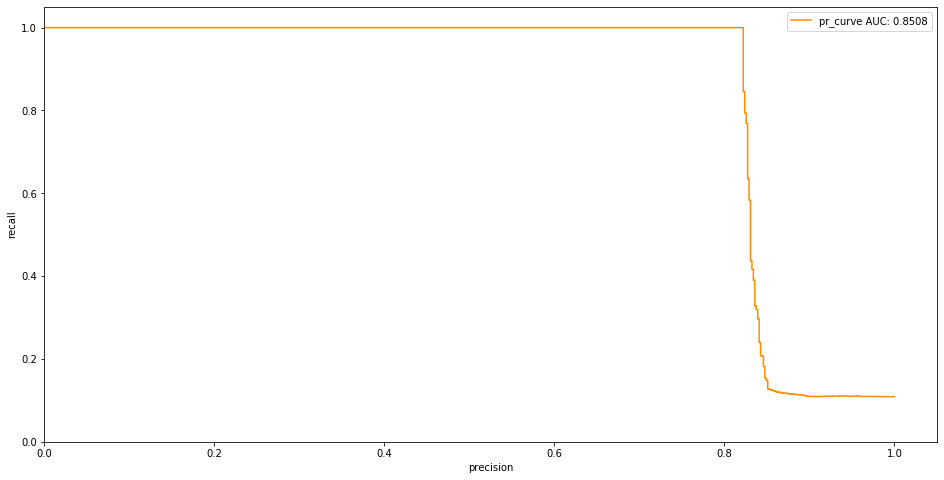

neoglia.learn.learner - INFO - 	- accuracy: 0.9144
neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0007


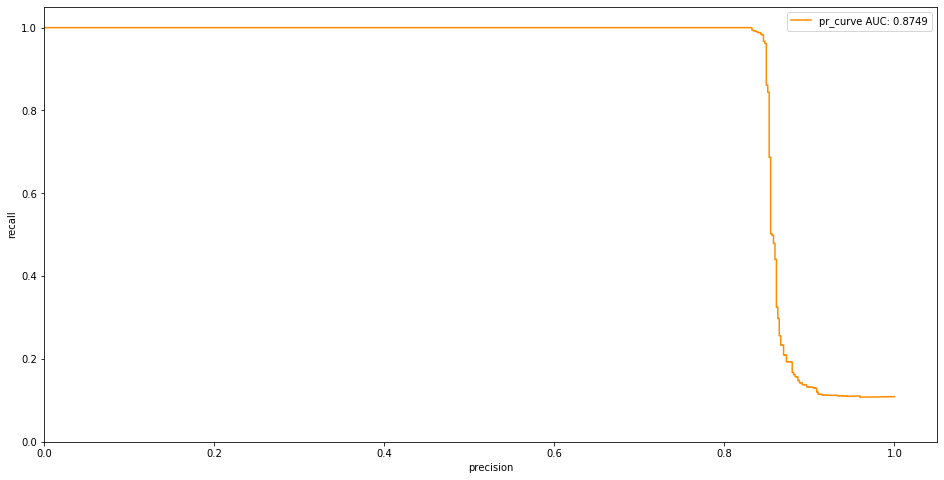

neoglia.learn.learner - INFO - 	- accuracy: 0.9399
neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0008


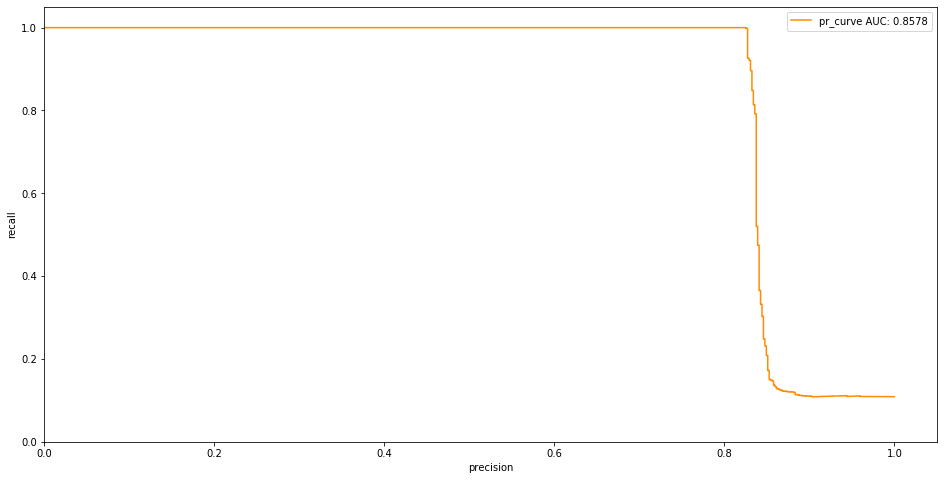

neoglia.learn.learner - INFO - 	- accuracy: 0.9216
neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0008


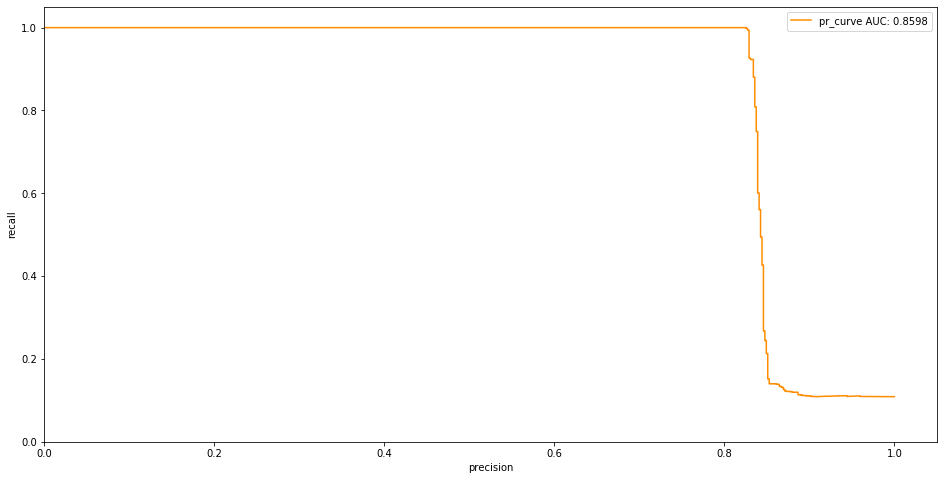

neoglia.learn.learner - INFO - 	- accuracy: 0.9236
neoglia.learn.learner - INFO - Starting epoch 31/50
neoglia.learn.learner - INFO - Training round: 31, worker: h2, avg_loss: 0.0365
neoglia.learn.learner - INFO - Training round: 31, worker: h1, avg_loss: 0.0215
neoglia.learn.learner - INFO - Training round: 31, worker: h3, avg_loss: 0.0235
neoglia.learn.learner - INFO - Starting epoch 32/50
neoglia.learn.learner - INFO - Training round: 32, worker: h2, avg_loss: 0.0454
neoglia.learn.learner - INFO - Training round: 32, worker: h3, avg_loss: 0.0414
neoglia.learn.learner - INFO - Training round: 32, worker: h1, avg_loss: 0.0191
neoglia.learn.learner - INFO - Starting epoch 33/50
neoglia.learn.learner - INFO - Training round: 33, worker: h2, avg_loss: 0.0265
neoglia.learn.learner - INFO - Training round: 33, worker: h3, avg_loss: 0.0340
neoglia.learn.learner - INFO - Training round: 33, worker: h1, avg_loss: 0.0495
neoglia.learn.learner - INFO - Starting epoch 34/50
neoglia.learn.learner

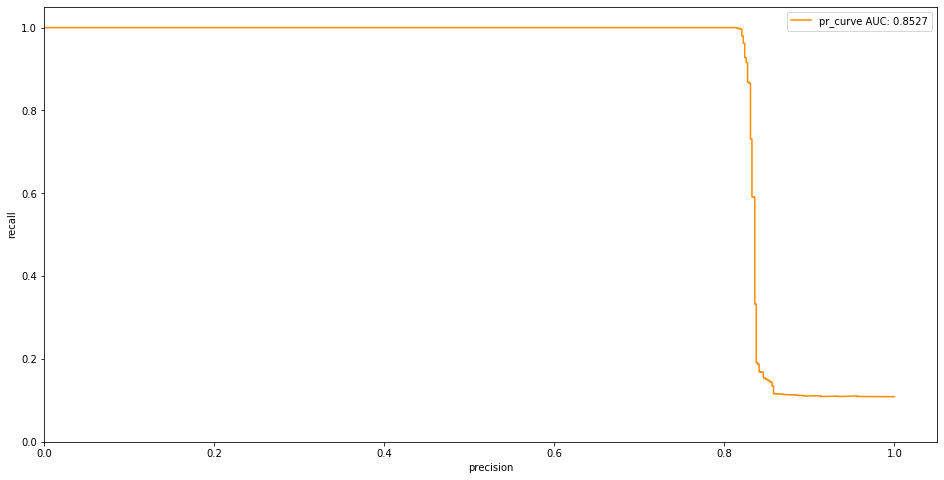

neoglia.learn.learner - INFO - 	- accuracy: 0.9203
neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0016


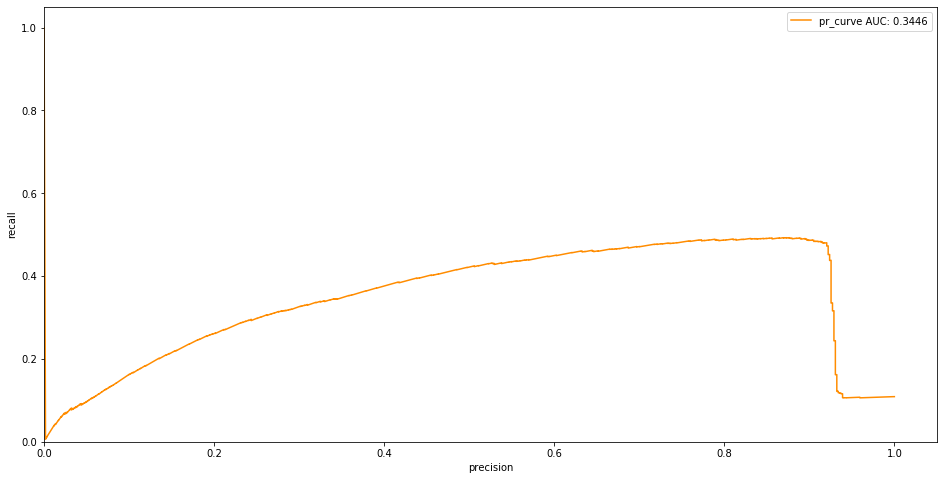

neoglia.learn.learner - INFO - 	- accuracy: 0.8836
neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0008


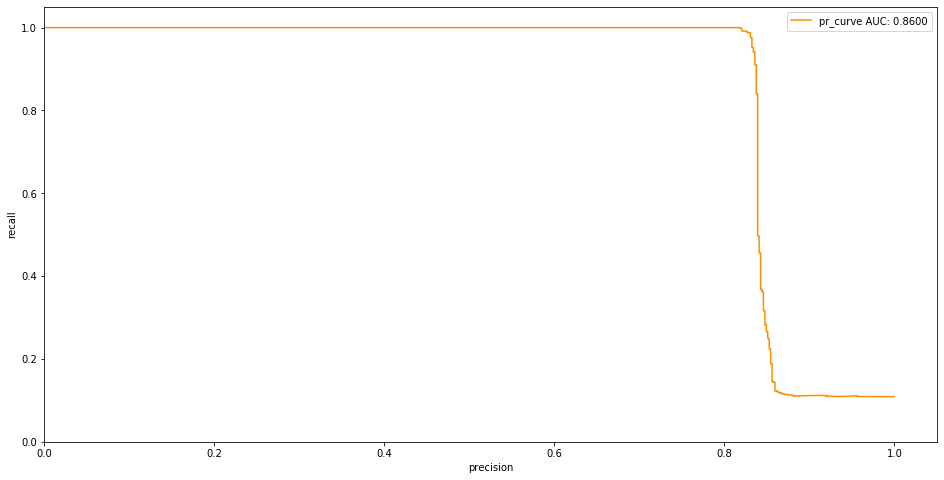

neoglia.learn.learner - INFO - 	- accuracy: 0.9327
neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0007


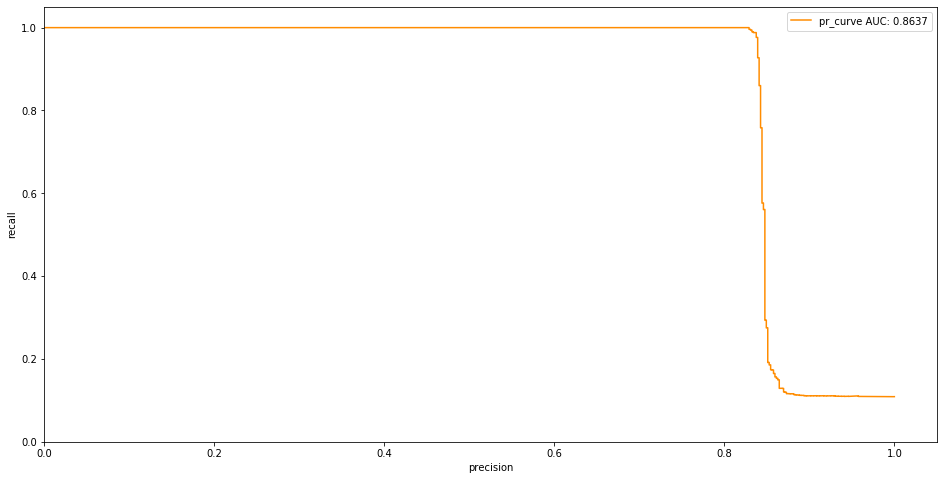

neoglia.learn.learner - INFO - 	- accuracy: 0.9410
neoglia.learn.learner - INFO - Starting epoch 41/50
neoglia.learn.learner - INFO - Training round: 41, worker: h2, avg_loss: 0.0779
neoglia.learn.learner - INFO - Training round: 41, worker: h1, avg_loss: 0.0305
neoglia.learn.learner - INFO - Training round: 41, worker: h3, avg_loss: 0.0253
neoglia.learn.learner - INFO - Starting epoch 42/50
neoglia.learn.learner - INFO - Training round: 42, worker: h2, avg_loss: 0.0623
neoglia.learn.learner - INFO - Training round: 42, worker: h3, avg_loss: 0.0318
neoglia.learn.learner - INFO - Training round: 42, worker: h1, avg_loss: 0.0185
neoglia.learn.learner - INFO - Starting epoch 43/50
neoglia.learn.learner - INFO - Training round: 43, worker: h2, avg_loss: 0.0732
neoglia.learn.learner - INFO - Training round: 43, worker: h3, avg_loss: 0.0150
neoglia.learn.learner - INFO - Training round: 43, worker: h1, avg_loss: 0.0294
neoglia.learn.learner - INFO - Starting epoch 44/50
neoglia.learn.learner

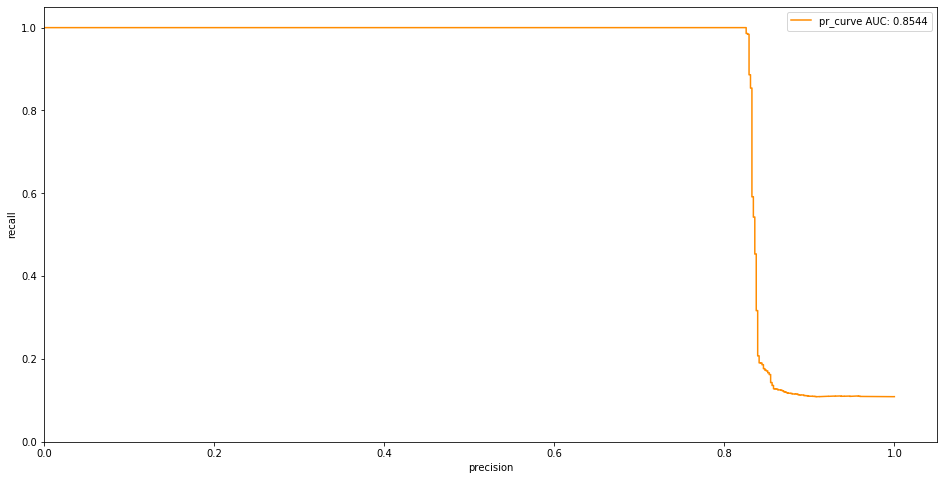

neoglia.learn.learner - INFO - 	- accuracy: 0.9290
neoglia.learn.learner - INFO - h2: Test set: Average loss: 0.0009


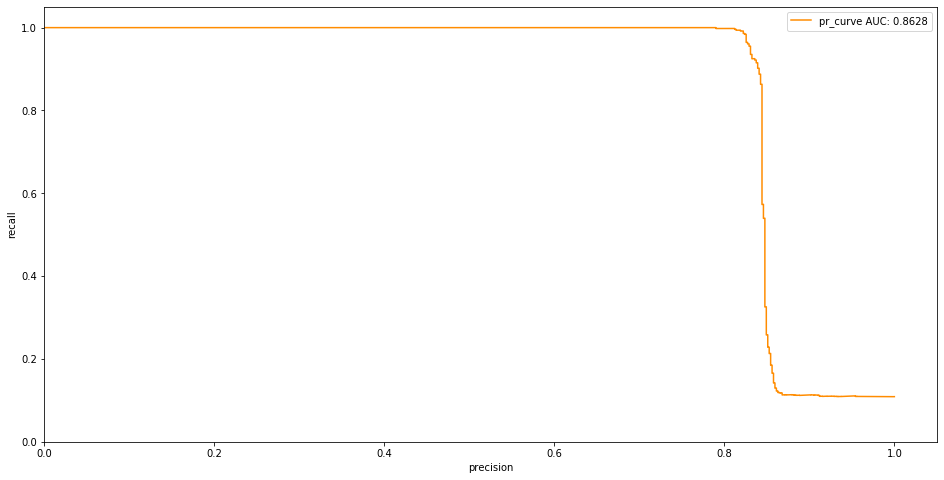

neoglia.learn.learner - INFO - 	- accuracy: 0.9293
neoglia.learn.learner - INFO - h3: Test set: Average loss: 0.0007


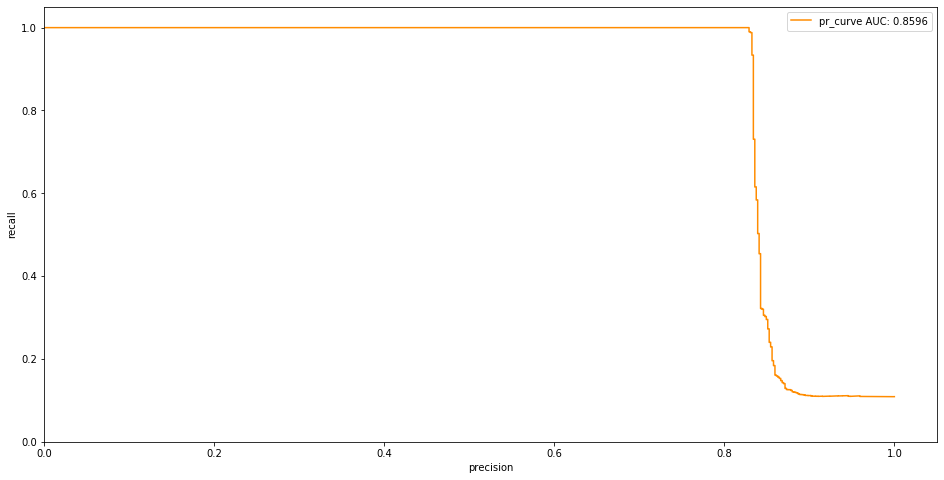

neoglia.learn.learner - INFO - 	- accuracy: 0.9437
neoglia.learn.learner - INFO - Federated model: Test set: Average loss: 0.0008


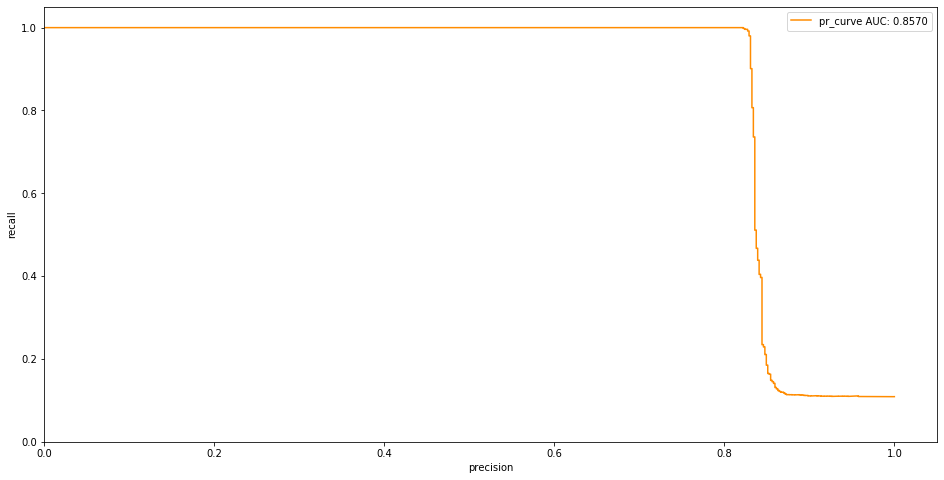

neoglia.learn.learner - INFO - 	- accuracy: 0.9340


In [10]:
fed_learner.train_eval()

In [11]:
for worker in (h1, h2, h3):
    worker.close()